# Closing the Loop on the L4-3 Crystal

In [66]:
import numpy as np
from chickpea.cma import CavityModeAnalysis
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cavity simulation in Chikpea

In the Legume tutorial
[Guided_mode_expansion_with_autograd](../docs/examples/06_Guided_mode_expansion_with_autograd.ipynb).
A L4/3 crystal is optimized for Q factor and modal volume of a particular mode. The mode analyzed in this tutorial
is chosen with prior knowledge of the mode structure. For novel crystals the mode structure may not be known in advance.
Can we apply the techniques of [Analyzing an H2 Photonic Crystal Cavity](02_Analyzing_an_H2_Photonic_Crystal_Cavity.ipynb)
to close the loop and conduct the optimization as if we had no prior knowledge?

Beginning in the same place as the legume tutorial by constructing the crystal we have:

In [67]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 10

# Regular PhC parameters
ra = 0.234
dslab = 0.4355
n_slab = 2.21

# Initialize a lattice and PhC
lattice = legume.Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(ny):
    for ix in range(nx):
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

# Move the first two holes to create the L4/3 defect
xp[0] = 2/5
xp[1] = 6/5
nc = len(xp)

In [68]:
# Construct the photonic crystal

# Initialize PhC
phc = legume.PhotCryst(lattice)

# Add a layer to the PhC
phc.add_layer(d=dslab, eps_b=n_slab**2)

# Apply holes symmetrically in the four quadrants
for ic, x in enumerate(xp):
    yc = yp[ic] if yp[ic] == 0 else yp[ic]
    xc = x if x == 0 else xp[ic]
    phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
    if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
        phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=ra))
    if nx-1.6 > xp[ic] > 0:
        phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=ra))
    if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
        phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=ra))

From here we diverge. What do the modes of the L4/3 Crystal look like? Applying the same techniques as in
[Analyzing an H2 Photonic Crystal Cavity](02_Analyzing_an_H2_Photonic_Crystal_Cavity.ipynb)

We construct the base crystal so that we may study the bandgap

In [69]:
a1 = np.array([0.5, np.sqrt(3)/2])
a2 = np.array([0.5, -np.sqrt(3)/2])

base_lattice = legume.Lattice(a1,a2)
base_phc = legume.PhotCryst(base_lattice)
base_phc.add_layer(d=dslab, eps_b=n_slab**2)
base_phc.layers[0].add_shape(legume.Circle(eps=1.0, r=ra))

defect_margins = np.array([0.25,0.25])
cma = CavityModeAnalysis(phc, base_phc, defect_margins, layer=0, gmax=3, base_gmax=3)

Where are the band gaps of this crystal?

<AxesSubplot:xlabel='Wave vector', ylabel='Frequency'>

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\tkinter\__init__.py", line 804, in callit
    func(*args)
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backend_bases.py", line 1544, in _draw
    def _draw(renderer): r

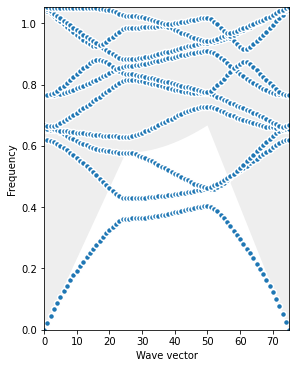

In [70]:
band_gaps, k_air, k_eps =cma.find_band_gaps(band_tol=0.025,
                                            order=np.array([0]), # The order of modes that we care about.
                                                                   # TE modes are numbers [0,2,4,6,8]
                                                                   # We happen to know that higher order modes are
                                                                   # well above the bandgap
                                            numeig=10, sample_rate=25)

gmg_ratio = np.array([(band_gap[1] - band_gap[0]) / band_gap[2] for band_gap in band_gaps])

# Because find_band_gaps runs a simulation on the base crystal, we can visualize the bands by
legume.viz.bands(cma.base_gme,  trim_light_cone=False, lc_trim=0)

You may notice that the number of kpoints we sample when finding the band gaps is higher the for the H2 crystal.
This is required as the band tolerance is small, and we don't want to detect frivolous band gaps between samples of
k.


In [71]:
# There is only one band-gap for this crystal with properties.
print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (band_gaps[0][0],
                                                                   band_gaps[0][1],
                                                                   band_gaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1],
                                                                   k_eps[0], k_eps[1]))

Band gap lower bound: 0.402868.
Band gap upper bound: 0.429419.
Band gap center: 0.416144.
Gap-midgap ratio: 0.063803.
The top of the air band is at k= (3.141593, 1.813799).
The bottom of the dielectric band is at k= (4.188790, 0.000000).



To find defect modes we run a guided mode expansion targeting the center of the gap.

In [ ]:
options = {'verbose': True,
           'gmode_inds': [0],
           'gradients': 'approx',
           'numeig': 10,
           'eig_solver': 'eigh',
           'eig_sigma': band_gaps[0][2],
           'compute_im': False
        }

cma.gme.run(kpoints=np.array([[0],[0]]), **options)

Because we simulated outside the light cone we can filter cavity modes by
restricting the frequency range to the band gap and filtering off high mode volume modes.

In [ ]:

arg_list, v = cma.filter_for_defect_mode(max_volume=10, band_filter=band_gaps)
q, freqs_im, rad_coup, rad_gvec = cma.calculate_loss_rates_and_coupling(arg_list)


Finally, knowing the mode volume and the Q factor of our we plot the magnitude of the y component of the electric field.
We see that we have recovered the mode chosen in the original tutorial, and we have done so without
any prior knowledge other than the permittivity distribution of the crystal.

In [ ]:
for kind, mlist in enumerate(arg_list):
    for i, mind in enumerate(mlist):
        fig=legume.viz.field(cma.gme,'E', kind, mind, z=dslab/2, component='y', val='abs', N1=200, N2=200, norm=True)
        fig.text(0.5,-0.25,
                 "arg: " + str(mind)+ "\n"
                 + "freq: " + str(cma.gme.freqs[kind][mind]) + "\n"
                 + "Volume: " + str(v[kind][i]) + "\n"
                 + "Q: " + str(q[kind][i]))

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\tkinter\__init__.py", line 1883, in __call__
    return self.func(*args)
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\tkinter\__init__.py", line 804, in callit
    func(*args)
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\_backend_tk.py", line 253, in idle_draw
    self.draw()
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_tkagg.py", line 9, in draw
    super(FigureCanvasTkAgg, self).draw()
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backends\backend_agg.py", line 407, in draw
    self.figure.draw(self.renderer)
  File "c:\users\stephen\appdata\local\programs\python\python38\lib\site-packages\matplotlib\backend_bases.py", line 1544, in _draw
    def _draw(renderer): r

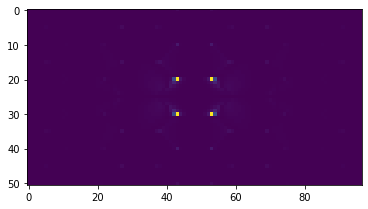